# XGBoost stock prediction

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


In [2]:
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(1592, 1) (397, 1)


In [3]:
bert_embeddings = np.load('../bert_embeddings.npy')

bert_train = bert_embeddings[:training_data_len]
bert_test = bert_embeddings[training_data_len:]
print(bert_train.shape, bert_test.shape)

(1592, 1, 768) (397, 1, 768)


In [4]:
fingpt_sentiments = np.load('../fingpt_sentiment.npy').astype('float32') 

fingpt_sentiments = fingpt_sentiments.reshape(-1, 1)
sentiments_train = fingpt_sentiments[:training_data_len]
sentiments_test = fingpt_sentiments[training_data_len:]

print(sentiments_train.shape, sentiments_test.shape)

(1592, 1) (397, 1)


In [5]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [7]:
scaled_train.shape

(1592, 1)

In [8]:
sentiments_train.shape

(1592, 1)

In [9]:
y_p = torch.tensor(scaled_train, dtype=torch.float32).float()
X_e = torch.tensor(bert_train, dtype=torch.float32).float()
X_s = torch.tensor(sentiments_train, dtype=torch.float32).float()

X_train = torch.cat((X_e.squeeze(), X_s), axis=1)
y_train = y_p

X_train.shape, y_train.shape

(torch.Size([1592, 769]), torch.Size([1592, 1]))

In [10]:
X_p = torch.tensor(scaled_test, dtype=torch.float32).float()
X_e = torch.tensor(bert_test, dtype=torch.float32).float()
X_s = torch.tensor(sentiments_test, dtype=torch.float32).float()

X_test = torch.cat(( X_e.squeeze(), X_s), axis=1)
y_test = X_p
X_test.shape, y_test.shape

(torch.Size([397, 769]), torch.Size([397, 1]))

## Modelling

/Users/baga_nuhkadiev/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:40:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.20353	eval-rmse:0.28641
[1]	train-rmse:0.17959	eval-rmse:0.28428
[2]	train-rmse:0.16272	eval-rmse:0.28463
[3]	train-rmse:0.14451	eval-rmse:0.28123
[4]	train-rmse:0.12860	eval-rmse:0.28097
[5]	train-rmse:0.11757	eval-rmse:0.27997
[6]	train-rmse:0.10629	eval-rmse:0.27910
[7]	train-rmse:0.09833	eval-rmse:0.27797
[8]	train-rmse:0.08996	eval-rmse:0.27876
[9]	train-rmse:0.08315	eval-rmse:0.27998
[10]	train-rmse:0.07678	eval-rmse:0.27996
[11]	train-rmse:0.06881	eval-rmse:0.27900
[12]	train-rmse:0.06555	eval-rmse:0.27912
[13]	train-rmse:0.06201	eval-rmse:0.27866
[14]	train-rmse:0.05924	eval-rmse:0.27751
[15]	train-rmse:0.05453	eval-rmse:0.27730
[16]	train-rmse:0.05077	eval-rmse:0.27646
[17]	train-rmse:0.04859	eval-rmse:0.27649
[18]	train-rmse:0.04601	eval-rmse:0.27701
[19]	train-rmse:0.04378	eval-rmse:0.27657
[20]	train-rmse:0.04126	eval-rmse:0.27647
[21]	train-rmse:0.03992	eval-rmse:0.27650
[22]	train-rmse:0.03626	eval-rmse:0.27670
[23]	train-rmse:0.03413	eval-rmse:0.27660
[2

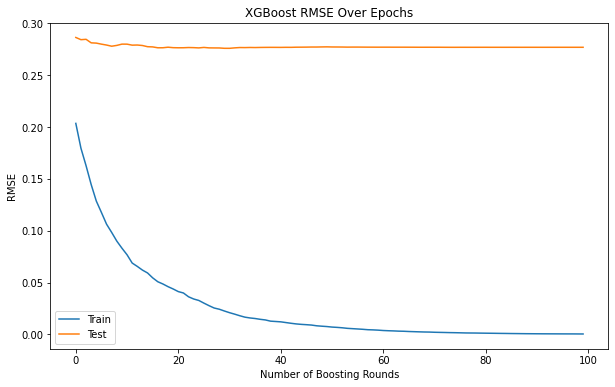

[0.54340434 0.594894   0.62442863 0.59386903 0.48984146 0.4181215
 0.33431286 0.38381886 0.55740875 0.64865977]
RMSE: 0.2769392728805542


In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'n_estimators': 1000
}

# Train the model and capture evaluation results
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dtest, 'eval')],
                  evals_result=evals_result, verbose_eval=True)

# Plot the training and evaluation loss
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['eval']['rmse'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs')
plt.show()

# Make predictions on the test set
predictions = model.predict(dtest)

# Print out a few predictions
print(predictions[:10])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")


In [12]:
predictions = model.predict(dtest)
with torch.no_grad():
    t = scaler.inverse_transform(y_test)
    tp = scaler.inverse_transform(predictions.reshape(-1, 1))
math.sqrt(mean_squared_error(t, tp))    

734.5014170705749

In [15]:
with torch.no_grad():
    tpreds = model.predict(dtrain)
    tr = scaler.inverse_transform(y_train)
    trp = scaler.inverse_transform(tpreds.reshape(-1, 1))
    print(math.sqrt(mean_squared_error(tr, trp)))


1.0064742102825228


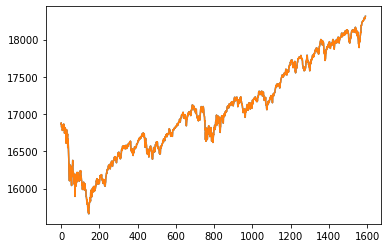

In [16]:
import matplotlib.pyplot as plt

plt.plot(tr)
plt.plot(trp)

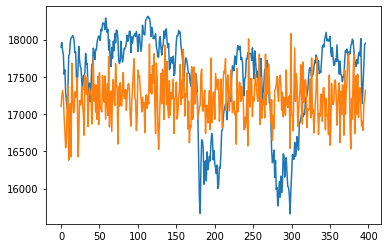

In [17]:
plt.plot(t)
plt.plot(tp)
